Первые 5 строк данных:


,group,task,variant,time,status,code
0,10,1,17,2022-02-18 13:14:47.817877,2,import math\n\ndef main(x):\n if x < 55:\n ...
1,10,0,10,2022-02-18 13:16:58.628887,2,"from math import ceil, sqrt\n\ndef f(y):\n ..."
2,10,0,17,2022-02-18 13:17:39.223111,2,import math\n\ndef main(x):\n return math.s...
3,10,0,20,2022-02-18 13:18:30.870201,2,import math\n\ndef main(x):\n a = 14 * x * ...
4,10,0,24,2022-02-18 13:18:41.487055,2,"from math import sqrt, asin, log10\n\ndef main..."



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14070 entries, 0 to 14069
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   group    14070 non-null  int64 
 1   task     14070 non-null  int64 
 2   variant  14070 non-null  int64 
 3   time     14070 non-null  object
 4   status   14070 non-null  int64 
 5   code     14070 non-null  object
dtypes: int64(4), object(2)
memory usage: 659.7+ KB


None


Статистика по числовым полям:


,group,task,variant,status
count,14070.000000,14070.000000,14070.000000,14070.0
mean,26.087704,4.927576,15.051173,2.0
std,14.756791,3.170933,9.353359,0.0
min,1.000000,0.000000,0.000000,2.0
25%,13.000000,2.000000,7.000000,2.0
50%,25.000000,5.000000,15.000000,2.0
75%,39.000000,8.000000,23.000000,2.0
max,52.000000,10.000000,39.000000,2.0



Количество уникальных значений:


group         52
task          11
variant       40
time       14070
status         1
code       13994
dtype: int64


Всего уникальных AST-узлов: 92
Примеры узлов: ['Add', 'And', 'AnnAssign', 'Assert', 'Assign', 'Attribute', 'AugAssign', 'BinOp', 'BitAnd', 'BitOr']

Форма матрицы признаков: (1367, 92)
Пример первых 5 строк и 5 столбцов:


,Add,And,AnnAssign,Assert,Assign
0,0.029292,0.000742,0.0,0.0,0.028550
1,0.014349,0.000000,0.0,0.0,0.044518
2,0.033405,0.000857,0.0,0.0,0.029979
3,0.010482,0.001572,0.0,0.0,0.036164
4,0.009341,0.000492,0.0,0.0,0.038348


C:\Users\ksura\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Creating interactive dendrogram...


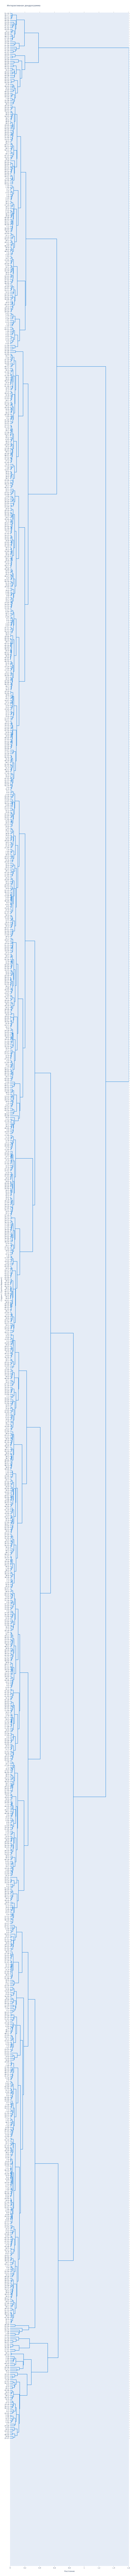


Компактная дендрограмма (первые 50 кластеров):


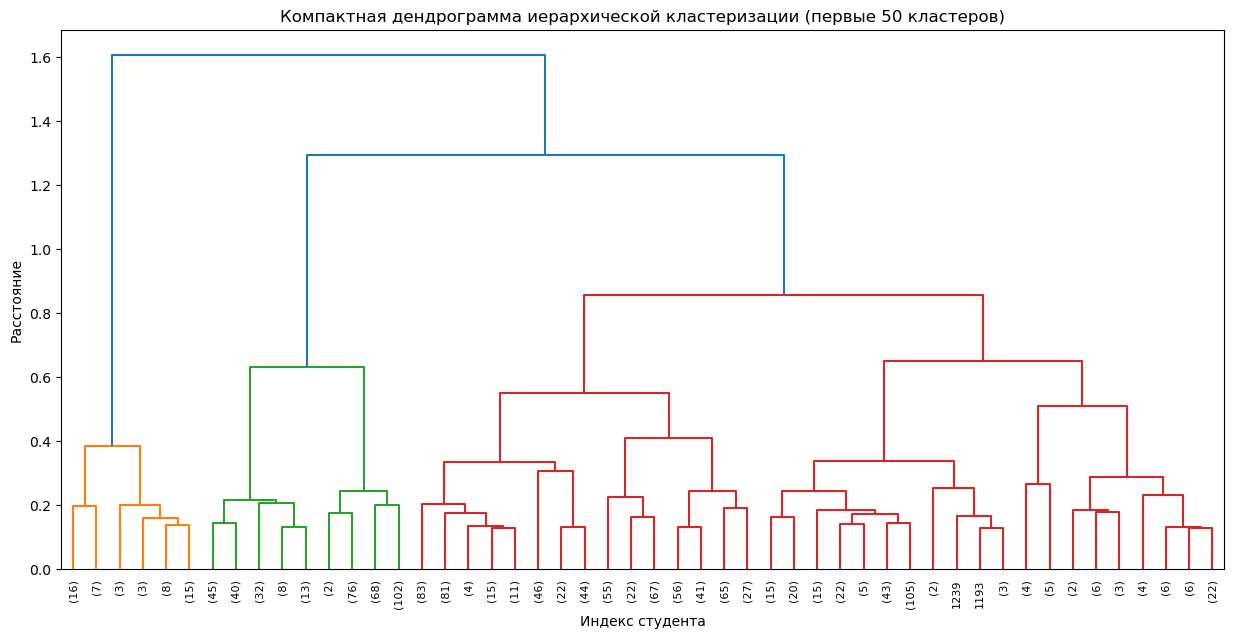

In [12]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
import umap
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from plotly.figure_factory import create_dendrogram

# Загрузка данных
df = pd.read_csv("dataset-2022.csv", header=None)
df.columns = ["group", "task", "variant", "time", "status", "code"]

# Вывод структуры данных для исследования
print("Первые 5 строк данных:")
display(df.head())

print("\nИнформация о данных:")
display(df.info())

print("\nСтатистика по числовым полям:")
display(df.describe())

print("\nКоличество уникальных значений:")
display(df.nunique())

# Объединение кодов для каждого студента
student_codes = df.groupby(['group', 'variant'])['code'].apply('\n'.join).reset_index()

# Функция для извлечения типов узлов AST
def extract_ast_node_types(code):
    try:
        tree = ast.parse(code)
    except Exception:
        return Counter()
    
    node_types = []
    stack = [tree]
    
    while stack:
        node = stack.pop()
        node_types.append(type(node).__name__)
        # Добавляем дочерние узлы в стек
        for child in ast.iter_child_nodes(node):
            stack.append(child)
    
    return Counter(node_types)

# Сбор всех уникальных типов узлов
all_node_types = set()
for code in student_codes['code']:
    node_types = extract_ast_node_types(code)
    all_node_types.update(node_types.keys())

# Сортировка для сохранения порядка
all_node_types = sorted(all_node_types)

# Вывод информации о признаках
print(f"\nВсего уникальных AST-узлов: {len(all_node_types)}")
print("Примеры узлов:", all_node_types[:10])

# Создание матрицы признаков
X = np.zeros((len(student_codes), len(all_node_types)))
for i, code in enumerate(student_codes['code']):
    node_counts = extract_ast_node_types(code)
    total_nodes = sum(node_counts.values())
    if total_nodes > 0:
        for j, node_type in enumerate(all_node_types):
            X[i, j] = node_counts.get(node_type, 0) / total_nodes

# Вывод информации о матрице признаков
print("\nФорма матрицы признаков:", X.shape)
print("Пример первых 5 строк и 5 столбцов:")
display(pd.DataFrame(X[:5, :5], columns=all_node_types[:5]))

# Иерархическая кластеризация
agg_clustering = AgglomerativeClustering(
    n_clusters=5, 
    metric='euclidean', 
    linkage='ward',
    compute_distances=True  # Important for dendrogram
)
clusters = agg_clustering.fit_predict(X)
student_codes['cluster'] = clusters

# Make sure indices are consistent
student_codes = student_codes.reset_index(drop=True)

# Визуализация с UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X)

# Интерактивный график кластеров - modified to handle indices safely
fig = go.Figure()
for cluster_id in sorted(student_codes['cluster'].unique()):
    cluster_mask = student_codes['cluster'] == cluster_id
    cluster_indices = cluster_mask[cluster_mask].index  # Get correct indices
    
    # Safely get embedding points
    x_points = embedding[cluster_indices, 0]
    y_points = embedding[cluster_indices, 1]
    
    hover_texts = [
        f"Group: {row['group']}<br>Variant: {row['variant']}<br>Cluster: {cluster_id}"
        for _, row in student_codes[cluster_mask].iterrows()
    ]
    
    fig.add_trace(go.Scatter(
        x=x_points,
        y=y_points,
        mode='markers',
        name=f'Cluster {cluster_id}',
        hovertext=hover_texts,
        hoverinfo='text'
    ))

# Modified cluster selector to use actual cluster IDs
cluster_selector = widgets.Dropdown(
    options=['All'] + sorted(student_codes['cluster'].unique().tolist()),
    value='All',
    description='Cluster:'
)

def update_plot(selected_cluster):
    for trace in fig.data:
        trace.visible = (selected_cluster == 'All') or (int(trace.name.split()[-1]) == selected_cluster)
        
widgets.interactive(update_plot, selected_cluster=cluster_selector)

# Modified dendrogram creation to handle indices properly
print("\nCreating interactive dendrogram...")
try:
    # Create labels that combine group and variant for better identification
    labels = [
        f"{row['group']}-{row['variant']}" 
        for _, row in student_codes.iterrows()
    ]
    
    # Create interactive dendrogram with proper labels
    dendro_fig = create_dendrogram(
        X,
        orientation='left',
        labels=labels,
        color_threshold=0,
        linkagefun=lambda x: linkage(X, method='ward')
    )
    
    dendro_fig.update_layout(
        title='Интерактивная дендрограмма',
        width=1000,
        height=max(600, len(student_codes) * 15),  # Dynamic height
        xaxis_title='Расстояние',
        yaxis_title='Студент (Группа-Вариант)'
    )
    dendro_fig.show()
except Exception as e:
    print(f"Error creating interactive dendrogram: {str(e)}")
    print("Creating simplified dendrogram instead...")
    
    plt.figure(figsize=(15, 10))
    Z = linkage(X, method='ward')
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=50,
        labels=labels,
        orientation='left',
        leaf_font_size=8
    )
    plt.title('Упрощенная дендрограмма (первые 50 кластеров)')
    plt.xlabel('Расстояние')
    plt.ylabel('Студент (Группа-Вариант)')
    plt.tight_layout()
    plt.show()

# Построение компактной дендрограммы (как было раньше)
print("\nКомпактная дендрограмма (первые 50 кластеров):")
plt.figure(figsize=(15, 7))
dendrogram(Z, truncate_mode='lastp', p=50, show_leaf_counts=True)
plt.title('Компактная дендрограмма иерархической кластеризации (первые 50 кластеров)')
plt.xlabel('Индекс студента')
plt.ylabel('Расстояние')
plt.show()

#### ГИПОТЕЗА:

студенты из одной группы чаще попадают в один кластер (т.к воруют друг у друга), чем студенты разных групп.

Распределение групп по кластерам:


group,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
cluster,,,,,,,,,,,,,,,,,,,,,
0,15,1,14,5,15,7,1,1,1,4,...,10,16,9,8,4,7,9,18,4,0
1,13,9,7,12,15,8,10,4,3,20,...,14,13,7,11,2,10,16,2,7,9
2,1,5,5,1,0,1,0,0,2,2,...,3,1,4,1,1,1,0,2,0,2
3,0,0,0,0,0,0,1,1,0,0,...,0,8,1,2,0,2,9,2,2,2
4,3,5,2,4,1,12,20,15,2,5,...,0,1,4,6,2,6,4,0,9,3


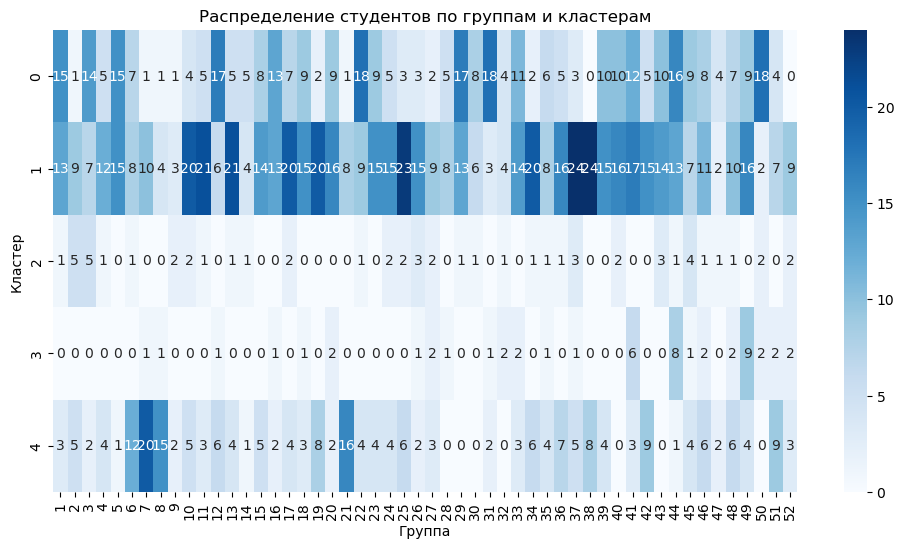


Результаты критерия хи-квадрат:
Хи-квадрат = 638.90
p-value = 0.0000
Степени свободы = 204

Вывод: Существует статистически значимая связь между группой и кластером (p < 0.05).
Гипотеза подтверждается - студенты из одной группы чаще попадают в один кластер.

Adjusted Rand Index между группами и кластерами: 0.008
Практически отсутствует связь между группами и кластерами.

Доля доминирующей группы в каждом кластере:


,cluster,dominant_group,dominant_group_ratio,num_students
4,3,49,0.173077,52
2,4,7,0.086207,232
3,2,3,0.086207,58
1,0,22,0.046632,386
0,1,37,0.037559,639


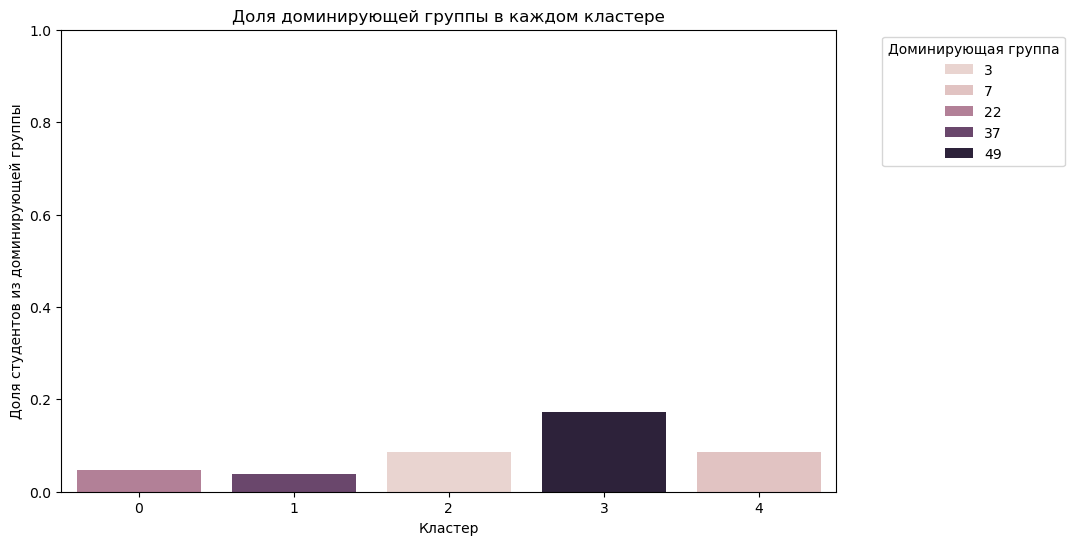

In [15]:
from sklearn.metrics import adjusted_rand_score
from scipy.stats import chi2_contingency
import seaborn as sns

# 1. Анализ распределения групп по кластерам
cluster_group_distribution = pd.crosstab(student_codes['cluster'], student_codes['group'])
print("Распределение групп по кластерам:")
display(cluster_group_distribution)

# Визуализация распределения
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_group_distribution, annot=True, fmt='d', cmap='Blues')
plt.title('Распределение студентов по группам и кластерам')
plt.xlabel('Группа')
plt.ylabel('Кластер')
plt.show()

# 2. Статистическая проверка гипотезы с помощью критерия хи-квадрат
chi2, p, dof, expected = chi2_contingency(cluster_group_distribution)
print(f"\nРезультаты критерия хи-квадрат:")
print(f"Хи-квадрат = {chi2:.2f}")
print(f"p-value = {p:.4f}")
print(f"Степени свободы = {dof}")

if p < 0.05:
    print("\nВывод: Существует статистически значимая связь между группой и кластером (p < 0.05).")
    print("Гипотеза подтверждается - студенты из одной группы чаще попадают в один кластер.")
else:
    print("\nВывод: Нет статистически значимой связи между группой и кластером (p ≥ 0.05).")
    print("Гипотеза не подтверждается.")

# 3. Расчет коэффициента Adjusted Rand Index между группами и кластерами
ari = adjusted_rand_score(student_codes['group'], student_codes['cluster'])
print(f"\nAdjusted Rand Index между группами и кластерами: {ari:.3f}")

# Интерпретация ARI
if ari > 0.5:
    print("Сильная связь между группами и кластерами.")
elif ari > 0.3:
    print("Умеренная связь между группами и кластерами.")
elif ari > 0.1:
    print("Слабая связь между группами и кластерами.")
else:
    print("Практически отсутствует связь между группами и кластерами.")

# 4. Дополнительный анализ: средняя доля одногруппников в кластере
cluster_stats = []
for cluster_id in student_codes['cluster'].unique():
    cluster_data = student_codes[student_codes['cluster'] == cluster_id]
    group_counts = cluster_data['group'].value_counts()
    same_group_ratio = (group_counts / len(cluster_data)).max()
    cluster_stats.append({
        'cluster': cluster_id,
        'dominant_group': group_counts.idxmax(),
        'dominant_group_ratio': same_group_ratio,
        'num_students': len(cluster_data)
    })

cluster_stats_df = pd.DataFrame(cluster_stats)
print("\nДоля доминирующей группы в каждом кластере:")
display(cluster_stats_df.sort_values('dominant_group_ratio', ascending=False))

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_stats_df, x='cluster', y='dominant_group_ratio', hue='dominant_group')
plt.title('Доля доминирующей группы в каждом кластере')
plt.xlabel('Кластер')
plt.ylabel('Доля студентов из доминирующей группы')
plt.ylim(0, 1)
plt.legend(title='Доминирующая группа', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()